In [1]:
import pandas as pd
import numpy as np
import argparse
import random
from graph_recommend.kgcn_model import KGCN
from graph_recommend.data_loader import DataLoader
import torch
import torch.optim as optim
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

print("finish import")

finish import


## 一、初始化超参数

In [2]:
parser = argparse.ArgumentParser()

parser.add_argument('--dataset', type=str, default='food', help='which dataset to use')
parser.add_argument('--aggregator', type=str, default='sum', help='which aggregator to use')
parser.add_argument('--n_epochs', type=int, default=80, help='the number of epochs')
parser.add_argument('--neighbor_sample_size', type=int, default=8, help='the number of neighbors to be sampled')
parser.add_argument('--dim', type=int, default=16, help='dimension of user and entity embeddings')
parser.add_argument('--n_iter', type=int, default=1, help='number of iterations when computing entity representation')
parser.add_argument('--batch_size', type=int, default=32, help='batch size')
parser.add_argument('--l2_weight', type=float, default=1e-4, help='weight of l2 regularization')
parser.add_argument('--lr', type=float, default=5e-4, help='learning rate')
parser.add_argument('--ratio', type=float, default=0.8, help='size of training dataset')

args = parser.parse_args(['--l2_weight', '1e-4'])



## 二、构建数据集以及知识图谱

In [3]:
data_loader = DataLoader(args.dataset)
kg = data_loader.load_kg()
df_dataset = data_loader.load_dataset()
df_dataset

Construct knowledge graph ... Done
Build dataset dataframe ... Done


,userID,itemID,label
0,856,566,1
1,541,588,1
2,866,585,1
3,418,603,1
4,152,48,1
...,...,...,...
17028,987,539,1
17029,683,595,1
17030,981,1076,0
17031,549,1376,0


## 三、训练模型

In [5]:
class KGCNDataset(torch.utils.data.Dataset):
    def __init__(self, df):
        self.df = df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        user_id = np.array(self.df.iloc[idx]['userID'])
        item_id = np.array(self.df.iloc[idx]['itemID'])
        label = np.array(self.df.iloc[idx]['label'], dtype=np.float32)
        return user_id, item_id, label


In [6]:
x_train, x_test, y_train, y_test = train_test_split(df_dataset, df_dataset['label'], test_size=1 - args.ratio,
                                                    shuffle=False, random_state=999)
train_dataset = KGCNDataset(x_train)
test_dataset = KGCNDataset(x_test)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=args.batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=args.batch_size)

In [7]:
# prepare network, loss function, optimizer
num_user, num_entity, num_relation = data_loader.get_num()
user_encoder, entity_encoder, relation_encoder = data_loader.get_encoders()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net = KGCN(num_user, num_entity, num_relation, kg, args, device).to(device)
criterion = torch.nn.BCELoss()
optimizer = optim.Adam(net.parameters(), lr=args.lr, weight_decay=args.l2_weight)
print('device: ', device)


device:  cpu


In [7]:
# train
loss_list = []
test_loss_list = []
auc_score_list = []

for epoch in range(args.n_epochs):
    running_loss = 0.0
    for i, (user_ids, item_ids, labels) in enumerate(train_loader):
        user_ids, item_ids, labels = user_ids.to(device), item_ids.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = net(user_ids, item_ids)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # print train loss per every epoch
    print('[Epoch {}]train_loss: '.format(epoch + 1), running_loss / len(train_loader))
    loss_list.append(running_loss / len(train_loader))

    # evaluate per every epoch
    with torch.no_grad():
        test_loss = 0
        total_roc = 0
        for user_ids, item_ids, labels in test_loader:
            user_ids, item_ids, labels = user_ids.to(device), item_ids.to(device), labels.to(device)
            outputs = net(user_ids, item_ids)
            test_loss += criterion(outputs, labels).item()
            total_roc += roc_auc_score(labels.cpu().detach().numpy(), outputs.cpu().detach().numpy())
        print('[Epoch {}]test_loss: '.format(epoch + 1), test_loss / len(test_loader))
        test_loss_list.append(test_loss / len(test_loader))
        auc_score_list.append(total_roc / len(test_loader))


[Epoch 1]train_loss:  1.0081272181210943
[Epoch 1]test_loss:  0.9748131098034226
[Epoch 2]train_loss:  0.8861121105755998
[Epoch 2]test_loss:  0.8812586447902929
[Epoch 3]train_loss:  0.7960078323111288
[Epoch 3]test_loss:  0.810901819545532
[Epoch 4]train_loss:  0.7350502107904551
[Epoch 4]test_loss:  0.7620744749764415
[Epoch 5]train_loss:  0.6956323751821204
[Epoch 5]test_loss:  0.7300008930892588
[Epoch 6]train_loss:  0.6698538071952516
[Epoch 6]test_loss:  0.7088098292038819
[Epoch 7]train_loss:  0.6514485199966341
[Epoch 7]test_loss:  0.6937262560719641
[Epoch 8]train_loss:  0.636282270363239
[Epoch 8]test_loss:  0.6816520356686315
[Epoch 9]train_loss:  0.6219686210994989
[Epoch 9]test_loss:  0.6707825209492835
[Epoch 10]train_loss:  0.6073227261013828
[Epoch 10]test_loss:  0.6602525154006815
[Epoch 11]train_loss:  0.5919465950117425
[Epoch 11]test_loss:  0.6497531744921319
[Epoch 12]train_loss:  0.575785873011804
[Epoch 12]test_loss:  0.6393741383173756
[Epoch 13]train_loss:  0.

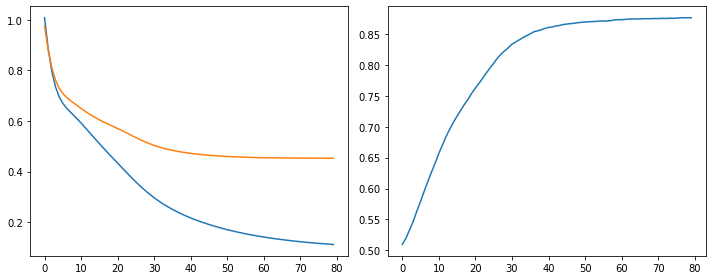

In [8]:
# plot losses / scores
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))  # 1 row, 2 columns
ax1.plot(loss_list)
ax1.plot(test_loss_list)
ax2.plot(auc_score_list)

plt.tight_layout()

In [8]:
# 保存模型
PATH = "graph_recommend/features/kgcn_features.pth"
# torch.save(net.state_dict(), PATH)

loaded_model = KGCN(num_user, num_entity, num_relation, kg, args, device)
loaded_model.load_state_dict(torch.load(PATH))
loaded_model.eval()
loaded_model

KGCN(
  (aggregator): Aggregator(
    (weights): Linear(in_features=16, out_features=16, bias=True)
  )
  (usr): Embedding(1000, 16)
  (ent): Embedding(1614, 16)
  (rel): Embedding(3, 16)
)

## 四、测试推荐结果


In [9]:
df_rating = pd.read_csv("data/user_item.txt", sep='\t', header=None, names=['userID', 'itemID', 'rating'])
chart = pd.read_csv("data/item_detail.txt", sep='\t', header=None,
                    names=['id', 'name', 'taste', 'cuisine', 'cooking_method', 'url'])
item_ids = chart['id']
item_ids


0          0
1          4
2          7
3         10
4         11
        ... 
1552    1609
1553    1610
1554    1611
1555    1612
1556    1613
Name: id, Length: 1557, dtype: int64

In [10]:
user_id = 39

fav_foods = df_rating[df_rating['userID'] == 39]['itemID']
user = torch.tensor([user_id])

score_list = []
for id in item_ids:
    if id not in fav_foods.values.tolist():
        item = torch.tensor([id])
        score = loaded_model(user, item)
        score_list.append([id, score])

sort_list = sorted(score_list, key=lambda t: t[1], reverse=True)

i = 0
res_str = ""
for t in sort_list[:10]:
    id = t[0]
    cur_item = chart[chart['id'].isin([id])]
    cur_item.reset_index(inplace=True, drop=True)
    name = cur_item.at[0, 'name']
    cuisine = cur_item.at[0, 'cuisine']
    res_str = res_str + str(id) + " " + name + " " + cuisine + " "

print("Top-K 推荐菜:")
print(res_str)

Top-K 推荐菜:
335 糯米酒酿鸡翅根 粤菜 601 蛋酱炒面 江西菜 280 汽水肉蒸蛋 粤菜 346 牛奶红豆杯 粤菜 259 白云凤爪 粤菜 307 汕头牛筋丸汤河粉 粤菜 354 鱿鱼土豆汤 粤菜 343 鱿鱼豆角情 粤菜 301 虾韮菜煎蛋 粤菜 264 自制广式腊肉 粤菜 
